In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan,acorr_breusch_godfrey
from statsmodels.compat import lzip
import csv
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sn
import statistics
from scipy import stats
import numpy.linalg
from scipy.stats import spearmanr,pearsonr, kstest,shapiro, anderson, normaltest
import math


ImportError: cannot import name 'factorial' from 'scipy.misc' (C:\Users\Daria_Riazanova\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\misc\__init__.py)

In [ ]:
!conda install scikit-learn

In [ ]:
!pip uninstall scikit-learn
!pip install scikit-learn==0.18.2

Забираем данные из файла и сортируем по дате. 

In [16]:
master_data=pd.read_csv('Bitcoin_Historical_Price.csv')
master_data.sort_values(by='Date',ascending = False)
df = pd.read_csv('Bitcoin_Historical_Price.csv',parse_dates=['Date'])
df = df.set_index('Date')
data =df.iloc[1300:,]
data.asfreq('W') 

,Close
Date,
2016-11-20,739.25
2016-11-27,735.81
2016-12-04,NaN
2016-12-11,NaN
2016-12-18,792.71
2016-12-25,907.61
2017-01-01,1021.75
2017-01-08,2710.67
2017-01-15,831.53


In [17]:
data.describe()

,Close
count,472.000000
mean,4689.440763
std,4604.976902
min,731.030000
25%,1148.460000
50%,2679.295000
75%,6814.300000
max,19497.400000


Построим график временного ряда

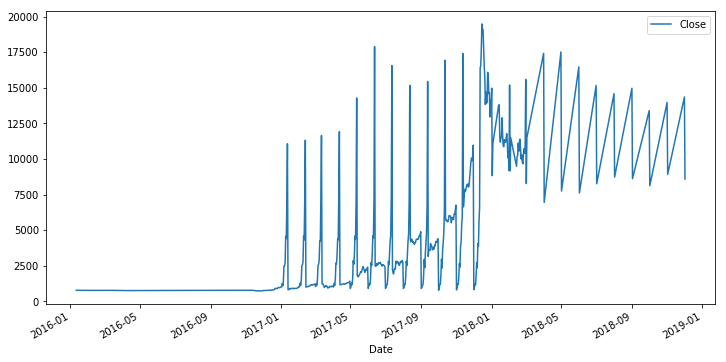

In [18]:
# data_30 = pd.Series(master_data)
data.plot(figsize=(12,6))


ACF and PACF 

NameError: name 'smt' is not defined

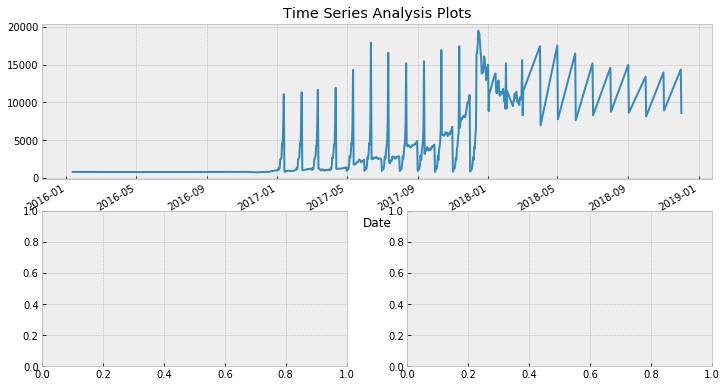

In [23]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        print("Критическое значение",sm.tsa.stattools.adfuller(y)[4])

        plt.tight_layout()
    return 

tsplot(data.Close, lags=30)

Получили стационарный ряд

In [ ]:
acf_plot = pd.DataFrame(acf(data['Close'], nlags=772))
acf_plot.columns=['ACF']
acf_plot.plot(kind='bar',figsize=(20,10))

In [ ]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# series = Series(data)
plot_acf(data['Close'])
plt.show()

In [ ]:
itog = data.describe()
data.hist()
itog

In [ ]:
otg1diff = data.diff(periods=1).dropna()
# print(otg1diff)
test = sm.tsa.adfuller(otg1diff.Close)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

In [ ]:
otg2diff = data.diff(periods=2).dropna()
# print(otg1diff)
test = sm.tsa.adfuller(otg2diff.Close)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

In [ ]:
# result = seasonal_decompose(data.Close.values, freq=7,model='additive')
# fig = result.plot()
# plt.show()
# plot_mpl(fig
         
result = seasonal_decompose(data.Close.values,freq=7, model='multiplicative')
fig = result.plot()
plt.show()

In [ ]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

In [ ]:
model = sm.tsa.ARIMA(data, order=(1,2,1)).fit()
print (model.summary())

In [ ]:
from scipy.stats import spearmanr,pearsonr, kstest,shapiro, anderson, normaltest
est2=model
result = anderson(est2.resid)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
stat, p = normaltest(est2.resid)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
stat, p = shapiro(est2.resid)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
kstest(model.resid, 'norm')


In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan,acorr_breusch_godfrey
print('durbin_watson',durbin_watson(est2.resid))
print('nlag=2',acorr_breusch_godfrey(est2, nlags=2))
print('nlag=3',acorr_breusch_godfrey(est2, nlags=3))
print('nlag=4',acorr_breusch_godfrey(est2, nlags=4))